In [12]:
import numpy as np
import netCDF4 as nc
import xarray as xr
from scipy.interpolate import griddata, interp1d
from salishsea_tools import nc_tools,viz_tools
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from fancyimpute import KNN

In [13]:
fname = '/home/ssahu/saurav/JP_BC/cat_42_days_T.nc';

gridT = xr.open_dataset(fname);

In [14]:
gridT.keys

<bound method Mapping.keys of <xarray.Dataset>
Dimensions:            (bnds: 2, deptht: 50, time_counter: 43, x: 715, y: 1021)
Coordinates:
  * deptht             (deptht) float32 0.494025 1.54138 2.64567 3.81949 ...
  * time_counter       (time_counter) datetime64[ns] 2016-04-01T12:00:00 ...
  * y                  (y) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * x                  (x) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * bnds               (bnds) int64 0 1
Data variables:
    nav_lon            (y, x) float32 -142.283 -142.256 -142.228 -142.2 ...
    nav_lat            (y, x) float32 45.0491 45.0479 45.0467 45.0456 ...
    time_counter_bnds  (time_counter, bnds) float64 4.873e+07 4.881e+07 ...
    votemper           (time_counter, deptht, y, x) float64 0.0 8.881 8.905 ...
    vosaline           (time_counter, deptht, y, x) float64 0.0 33.14 33.13 ...
    sosstsst           (time_counter, y, x) float64 0.0 8.881 8.905 8.925 ...
    sosaline           (

In [15]:
#### Load JP's mask

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc');

tmask_JP = mask.variables['tmask'][0,:,55:400,446:701];
umask_JP = mask.variables['umask'][0,:,55:400,446:701];
vmask_JP = mask.variables['vmask'][0,:,55:400,446:701];

print(tmask_JP.shape, umask_JP.shape, vmask_JP.shape)

(50, 345, 255) (50, 345, 255) (50, 345, 255)


In [16]:
#### Slice out our domain of WCVI from JP and mask it at the same time saying the zero values as NAN

votemper_JP = np.array(gridT['votemper'][0,:,55:400,446:701]);
votemper_JP[...] = np.ma.masked_array(votemper_JP[...], mask = tmask_JP[...]);
votemper_JP[votemper_JP == 0] =['Nan'];

vosaline_JP = np.array(gridT['vosaline'][0,:,55:400,446:701]);
vosaline_JP[...] = np.ma.masked_array(vosaline_JP[...], mask = tmask_JP[...]);
vosaline_JP[vosaline_JP == 0] = ['Nan'];

glamt_bc_JP = np.array(gridT['nav_lon'][55:400,446:701]);
gphit_bc_JP = np.array(gridT['nav_lat'][55:400,446:701]);
deptht_JP = np.array(gridT['deptht'][:]);

In [17]:
vosaline_JP[:,0,0]

array([ 32.85047913,  32.8494606 ,  32.84786987,  32.84399796,
        32.84130096,  32.84194183,  32.8444519 ,  32.84753799,
        32.85254669,  32.85647964,  32.8595314 ,  32.86235046,
        32.86702728,  32.87555313,  32.88618469,  32.89451218,
        32.90081024,  32.90483093,  32.90930176,  32.92013931,
        32.95475769,  33.06747437,  33.2415123 ,  33.47072601,
        33.66275787,  33.83255005,  33.93229294,  33.96300888,
        33.97008896,  33.98950577,  34.0399704 ,  34.10607147,
        34.17634964,  34.25790787,  34.33724213,  34.39661026,
        34.45060349,  34.49922562,  34.54627991,  34.58870316,
        34.61618042,          nan,          nan,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan])

In [18]:
#### Load the WCVI points

fname_wcvi = '/ocean/ssahu/CANYONS/wcvi/grid/coordinates.nc'

with nc.Dataset(fname_wcvi, 'r') as coord:
    gphit_wcvi = coord.variables['gphit'][0,...];
    glamt_wcvi =  coord.variables['glamt'][0,...]; 
    
print((glamt_bc_JP[0,0],gphit_bc_JP[0,0]), (glamt_wcvi[0,0],gphit_wcvi[0,0]))

(-129.93523, 45.455914) (-127.00188120221485, 46.113550613066906)


In [19]:
X = glamt_bc_JP.flatten();

Y = gphit_bc_JP.flatten();

points = (X[:],Y[:]);

xi = (glamt_wcvi.flatten(), gphit_wcvi.flatten());

votemper_ic = np.zeros((votemper_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));
vosaline_ic = np.zeros((vosaline_JP.shape[0], glamt_wcvi.shape[0], glamt_wcvi.shape[1]));

for i,j in enumerate(votemper_JP[:,...]):
    votemper_ic[i,...] = np.reshape(griddata(points, votemper_JP[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)
    vosaline_ic[i,...] = np.reshape(griddata(points, vosaline_JP[i,...].flatten(), xi, method= 'linear'), glamt_wcvi.shape)



In [20]:
vosaline_ic[:,0,0]

array([ 32.47419656,  32.47339993,  32.472351  ,  32.47062415,
        32.46957545,  32.46912266,  32.46870302,  32.46790199,
        32.46697466,  32.46655073,  32.46634141,  32.4661859 ,
        32.4660519 ,  32.4658899 ,  32.46588335,  32.46623902,
        32.46850987,  32.47960524,  32.52179053,  32.63602269,
        32.85181797,  33.12211982,  33.38578935,  33.65309569,
        33.81709729,  33.93756474,  34.00150822,  34.03875474,
        34.0547015 ,  34.05655214,  34.07886744,  34.13459396,
        34.20362748,  34.26293978,  34.33264525,  34.39530034,
        34.4533169 ,  34.49530198,  34.5369522 ,  34.579813  ,
        34.62248934,  34.63830741,  34.64125478,          nan,
                nan,          nan,          nan,          nan,
                nan,          nan])

In [21]:
for i,j in enumerate(votemper_ic[:,...]):
    votemper_ic[i,...] = KNN(k=3).complete(votemper_ic[i,...]);
    vosaline_ic[i,...] = KNN(k=3).complete(vosaline_ic[i,...]);

Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.006
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 4 missing, elapsed time: 0.004
Imputing row 1/100 with 8 missing, elapsed time: 0.004
Imputing row 1/100 with 8 missing, elapsed time: 0.004
Imputing row 1/100 with 9 missing, elapsed time: 0.005
Imputing row 1/100 with 9 missing, elapsed time: 0.004
Imputing row 1/100 with 9 missing, elapsed time: 0.005
Imputing row 1/100 with 9 missing, elapsed time: 0.004
Imputing r

ValueError: Input matrix must have some non-missing values

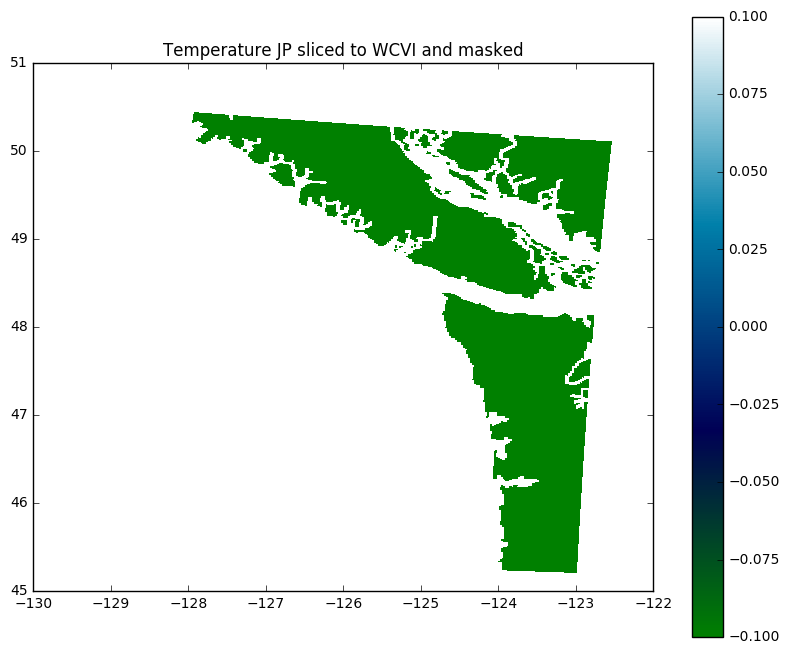

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_bc_JP, gphit_bc_JP,votemper_JP[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.title('Temperature JP sliced to WCVI and masked')
plt.show()

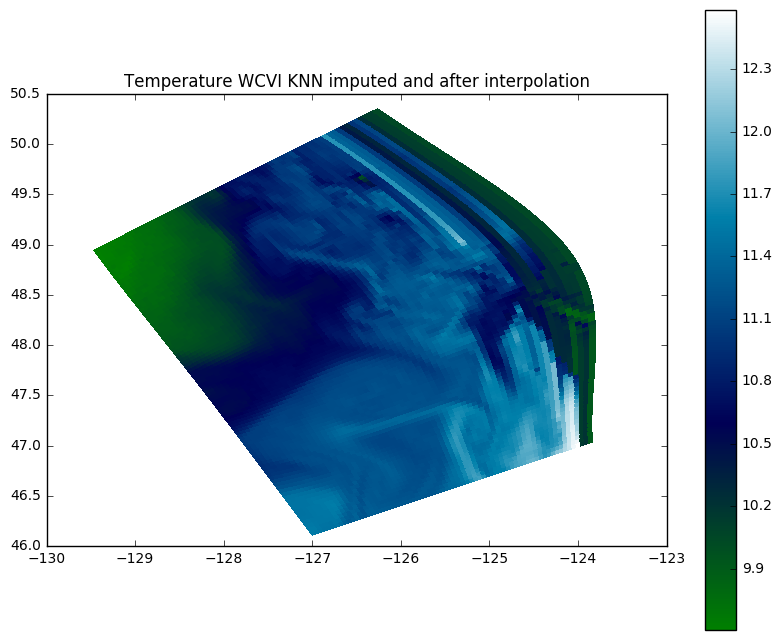

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
viz_tools.set_aspect(ax)

mesh = ax.pcolormesh(glamt_wcvi, gphit_wcvi,votemper_ic[0,...], cmap =cm.ocean)
fig.colorbar(mesh)
plt.title('Temperature WCVI KNN imputed and after interpolation')
plt.show()

In [25]:
file_temp = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc', 'w', zlib=True)
# dataset attributes
nc_tools.init_dataset_attrs(
    file_temp, 
    title='Temperature and salinity Initial Condition', 
    notebook_name='Making_IC_from_JP', 
    nc_filepath='/ocean/ssahu/CANYONS/wcvi/initial_conditions/West_coast_temperature_salinity_nomask_JP.nc',
    comment='Temperature and salinity from JP Model, preliminary_grid; used at all grid points')

file_temp.createDimension('xb', votemper_ic.shape[2]);
file_temp.createDimension('yb', votemper_ic.shape[1]);
file_temp.createDimension('deptht', votemper_ic.shape[0]);
file_temp.createDimension('time_counter', None);


nav_lat = file_temp.createVariable('nav_lat', 'float32', ('yb','xb'));
nav_lat.long_name = 'Latitude';
nav_lat.units = 'degrees_north';


nav_lon = file_temp.createVariable('nav_lon', 'float32', ('yb','xb'));
nav_lon.long_name = 'Longitude';
nav_lon.units = 'degrees_east';


deptht = file_temp.createVariable('deptht', 'float32', ('deptht'));
deptht.long_name = 'Vertical T Levels';
deptht.units = 'm';
deptht.positive = 'down';


time_counter = file_temp.createVariable('time_counter', 'float32', ('time_counter'));
time_counter.units = 's';
time_counter.long_name = 'time';
time_counter.calendar = 'noleap';


votemper = file_temp.createVariable('votemper', 'float32', ('time_counter','deptht','yb','xb'));
votemper.units = 'degC'
votemper.long_name = 'Temperature';
votemper.grid = 'WCVI';


vosaline = file_temp.createVariable('vosaline', 'float32', ('time_counter','deptht','yb','xb'));
vosaline.units = 'PSU';
vosaline.long_name = 'Practical Salinity';
vosaline.grid = 'WCVI';




nav_lat[:] = gphit_wcvi[:];
nav_lon[:] = glamt_wcvi[:];
deptht[:] = deptht_JP[:];
time_counter[0] = 1;
votemper[0,:] = votemper_ic[:]
vosaline[0,:]= vosaline_ic[:]

file_temp.close()





file format: NETCDF4
Conventions: CF-1.6
title: Temperature and salinity Initial Condition
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/canyonsubc/wcvi/src/tip/grid/Making_IC_from_JP.ipynb
references: REQUIRED
history: [2017-07-10 10:23:33] Created netCDF4 zlib=True dataset.
comment: Temperature and salinity from JP Model, preliminary_grid; used at all grid points


In [25]:
votemper_ic[0,...]

array([[ 11.53964838,  11.53109478,  11.5084218 , ...,  10.20964533,
          9.92389472,   9.99105759],
       [ 11.54100232,  11.54011288,  11.52218092, ...,  10.2102177 ,
          9.92409263,   9.9914599 ],
       [ 11.53083611,  11.53384   ,  11.52296658, ...,  10.21030544,
          9.92411766,   9.99117424],
       ..., 
       [  9.60923967,   9.62416414,   9.64059909, ...,  10.1225284 ,
         10.0440017 ,  10.81358997],
       [  9.60625478,   9.62655835,   9.60822421, ...,  10.12247906,
         10.04397908,  10.8121624 ],
       [  9.61543862,   9.62996737,   9.63071109, ...,  10.12242393,
         10.04396427,  10.81089077]])

In [ ]:
deptht.shape